# Room simulation with MUSDB18

In this notebook we will simulate a recording of *Perdrix* on a room on which we control certain parameters

We will then perform a Source Separation Algorithm on it.

In [1]:
import IPython.display as ipd
from IPython.display import display
import pickle
import librosa
import os
import matplotlib.pyplot as plt
import itertools
import operator
import soundfile as sf
import scipy as sp
import numpy as np
from numpy import typing
import pyroomacoustics as pra
from mir_eval.separation import bss_eval_sources
from src import performance, data_processing_copy, fast_nmf_copy
import stempeg
from pyroomacoustics.directivities import (
    DirectivityPattern,
    DirectionVector,
    CardioidFamily,
)

path_in = "./data/musdb18/train/"
path_musdb18 = "./data/musdb18/train/"
save_path = "./test/prise_de_son_perf/"

### Processing Data

In [2]:
# load the data
files_in, files_title = data_processing_copy.get_files(path_in)

### Parameters

In [3]:
# Room
room_dimension = [5, 9, 3]
abs_coef = 0.35
microphone_locations = np.c_[[1.5, 6, 1], [2, 7, 1], [3, 7, 1], [3.5, 6, 1], [2.5, 4.5, 1.5], [2.5, 4.5, 1.5], [2.5, 4.5, 1.5]]

appoint = DirectivityPattern.CARDIOID
couple = DirectivityPattern.CARDIOID

dir_1 = CardioidFamily(
    orientation = DirectionVector(azimuth=170, colatitude=90, degrees=True),
    pattern_enum = appoint,
)
dir_2_3 = CardioidFamily(
    orientation = DirectionVector(azimuth=90, colatitude=90, degrees=True),
    pattern_enum = appoint,
)
dir_4 = CardioidFamily(
    orientation = DirectionVector(azimuth=10, colatitude=90, degrees=True),
    pattern_enum = appoint,
)
dir_5 = CardioidFamily(
    orientation = DirectionVector(azimuth=60, colatitude=100, degrees=True),
    pattern_enum = couple,
)
dir_6 = CardioidFamily(
    orientation = DirectionVector(azimuth=90, colatitude=100, degrees=True),
    pattern_enum = couple,
)
dir_7 = CardioidFamily(
    orientation = DirectionVector(azimuth=120, colatitude=100, degrees=True),
    pattern_enum = couple,
)

directivities = [dir_1, dir_2_3, dir_2_3, dir_4, dir_5, dir_6, dir_7]

source_locations = [[1.2, 6.3, 1], [2, 7.5, 1], [3, 7.5, 1], [4.2, 6.3, 1]]
source_dir = None

# Audio processing

song_path = files_in[35]
start_time = 30
audio_length = 10
L=2048
hop=512

# Algorithm parameters

n_basis = 32
n_iter = 300

### Definitions

In [4]:
def shoebox_recording(
    room_dimension, 
    abs_coef, 
    microphone_locations,
    microphone_dir = None,
    rate = 44100,
    display_room = False,
    ):

    """ 
    
    this function creates a shoebox room (defined 
    with its geometry, room absorption, source 
    locations and microphones locations)

    Input
    ---
    - room_dimension:       Array [length, width, height]   = room dimensions
    - abs_coef:             float                           = Sabine absorbtion coefficient
    - microphone_locations: np.c_ [[3D locations],...]      = microphones locations
    - microphone_dir:       optionnal, directivity          = microphones directivity
    - rate:                 optionnal, int                  = rate of the microphone (44100 default)
    - display_room:         optionnal, bool                 = room display (False default)

    Output
    ---

    - room:                 ShoeBox                         = room

    """

    # Create an shoebox room
    room = pra.ShoeBox(room_dimension, fs=rate, max_order=15, absorption=abs_coef, sigma2_awgn=1e-8)

    # Add microphone array
    mic_array = pra.MicrophoneArray(microphone_locations, rate)
    room.add_microphone_array(mic_array, directivity=microphone_dir)
    
    if display_room:
        fig, ax = room.plot()
        lim = 9
        ax.set_xlim([0, lim])
        ax.set_ylim([0, lim])
        ax.set_zlim([0, lim])
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')

    return room

def compute_si_sdr(reference, estimation):
    """
    Fonction provenant du github https://github.com/fgnt/pb_bss et servant à estimer
    le si-sdr entre un signal de reference et un signal estimé


    Scale-Invariant Signal-to-Distortion Ratio (SI-SDR)
    Args:
        reference: numpy.ndarray, [..., T]
        estimation: numpy.ndarray, [..., T]
    Returns:
        SI-SDR
    [1] SDR– Half- Baked or Well Done?
    http://www.merl.com/publications/docs/TR2019-013.pdf
    >>> np.random.seed(0)
    >>> reference = np.random.randn(100)
    >>> si_sdr(reference, reference)
    inf
    >>> si_sdr(reference, reference * 2)
    inf
    >>> si_sdr(reference, np.flip(reference))
    -25.127672346460717
    >>> si_sdr(reference, reference + np.flip(reference))
    0.481070445785553
    >>> si_sdr(reference, reference + 0.5)
    6.3704606032577304
    >>> si_sdr(reference, reference * 2 + 1)
    6.3704606032577304
    >>> si_sdr([1., 0], [0., 0])  # never predict only zeros
    nan
    >>> si_sdr([reference, reference], [reference * 2 + 1, reference * 1 + 0.5])
    array([6.3704606, 6.3704606])
    """
    estimation, reference = np.broadcast_arrays(estimation, reference)

    assert reference.dtype == np.float64, reference.dtype
    assert estimation.dtype == np.float64, estimation.dtype

    reference_energy = np.sum(reference**2, axis=-1, keepdims=True)

    # This is $\alpha$ after Equation (3) in [1].
    optimal_scaling = (
        np.sum(reference * estimation, axis=-1, keepdims=True) / reference_energy
    )

    # This is $e_{\text{target}}$ in Equation (4) in [1].
    projection = optimal_scaling * reference

    # This is $e_{\text{res}}$ in Equation (4) in [1].
    noise = estimation - projection

    ratio = np.sum(projection**2, axis=-1) / np.sum(noise**2, axis=-1)
    return 10 * np.log10(ratio)

def compute_perf(y, ref):

    """
    Fonction permettant de calculer les performances de la méthode de séparation de sources
    suivant les critères SDR, SI-SDR, SIR et SAR.

    Inputs:
    ------------------------------------------------------

    y: numpy.ndarray (n_channels, n_sources, n_samples)
        Matrice contenant les signaux audios estimés

    ref: numpy.ndarray (n_channels, n_sources, n_samples)
        Matrice contenant les signaux audios de référence


    Outputs:
    ------------------------------------------------------

    sdr: list
        Liste contenant les valeurs de SDR pour chaque source

    si_sdr: list
        Liste contenant les valeurs de SI-SDR pour chaque source

    sir: list
        Liste contenant les valeurs de SIR pour chaque source

    sar: list
        Liste contenant les valeurs de SAR pour chaque source

    perm: list
        Liste contenant les permutations des sources estimées par rapport aux sources de référence

    """
    sdr = []
    si_sdr = []
    sir = []
    sar = []
    perm = []

    # On parcourt les microphones
    for i in range(y.shape[0]):

        # On prend le minimum entre le nombre de samples du signal de référence et celui de l'estimation
        m_ = np.minimum(y[i].shape[1], ref[i].shape[1])

        # On calcule les performances
        sdr_, sir_, sar_, perm_ = bss_eval_sources(ref[i, :, :m_], y[i, :, :m_])
        si_sdr_ = compute_si_sdr(ref[i, :, :m_], y[i, :, :m_])

        # On ajoute les performances pour tous les microphones
        sdr.append(sdr_)
        si_sdr.append(si_sdr_)
        sir.append(sir_)
        sar.append(sar_)
        perm.append(perm_)

    return sdr, si_sdr, sir, sar, perm

def ecoute_separation_micro(mic, y, save):
    """Fonction permettant d'écouter les audios séparés pour un micro donné et de les sauvegarder si save=True

    Args:
        mic (int): index du microphone dont on veut écouter la séparation
        y (array): array contenant les signaux audios séparés pour chaque microphones
        save (boolean): True si on veut sauvegarder les audios séparés, False sinon
    """

    for source_n in range(len(y[0])):
        print(
            "Listening of Audio at microphone "
            + str(mic)
            + " for source "
            + str(source_n)
        )
        display(ipd.Audio(y[mic][source_n], rate=44100))



### Compute it

In [21]:
def compute_all(
    room_dimension, 
    abs_coef, 
    microphone_locations, 
    directivities,
    shoebox_room, 
    source_locations, 
    source_dir, 
    song_path,
    start_time,
    audio_length,
    n_iter,
    n_basis,
    display_audio = False,
    display_room = False
    ):

    """Fonction permettant de calculer les performances d'une séparation audio

    Args:
        room_dimension          (list):             dimensions de la pièce
        abs_coef                (list):             coefficients d'absorption de la pièce
        microphone_locations    (list):             liste contenant les coordonnées des microphones
        directivities           (list):             liste contenant les directivités des microphones
        shoebox_room            (object):           objet contenant les informations de la pièce
        source_locations        (list):             liste contenant les coordonnées des sources
        source_dir              (list):             liste contenant les directions des sources
        song_path               (string):           chemin vers le fichier audio
        start_time              (int):              temps de début de l'enregistrement
        audio_length            (int):              durée de l'enregistrement
        n_iter                  (int):              nombre d'itérations
        n_basis                 (int):              nombre de bases
        L                       (int, optional):    taille de la fenêtre. Defaults to 2048.
        hop                     (int, optional):    pas de la fenêtre. Defaults to 512.
        display_audio           (bool, optional):   True si on veut afficher les audios. Defaults to False.
        display_room            (bool, optional):   True si on veut afficher la pièce. Defaults to False.

    Returns:
        likelihood              (list):             liste contenant les likelihoods
        overall_sdr             (float):            SDR moyen
        overall_sir             (float):            SIR moyen
        overall_sar             (float):            SAR moyen
        overall_si_sdr          (float):            SI-SDR moyen
    """

    shoebox_room = shoebox_recording(room_dimension, abs_coef, microphone_locations, directivities)

    X, separate_recordings, mics_signals = data_processing_copy.room_spectrogram_from_musdb(
        shoebox_room, 
        source_locations, 
        source_dir, 
        song_path,
        start_time,
        audio_length
        )

    ### Running FastMNMF2_split algorithm ###

    Y, W_NFK, E_NFL, U_NLK, H_NKT, Y_FTM, T_NKO, P_NOT, g_NM, Q_FMM, likelihood = fast_nmf_copy.fastmnmf2_split(
    X.transpose(1, 2, 0),
    E_NFL=None,
    P_NOT=None,
    n_src=4,
    n_iter=n_iter,
    n_components=n_basis,
    n_notes=X.shape[2] - 1,
    n_activations=X.shape[1] - 1,
    mic_index="all",
    )

    Y = Y.transpose(0, 3, 2, 1)

    ### Reconstructing the signals ###

    # STFT parameters
    win_a = pra.hamming(L)
    win_s = pra.transform.stft.compute_synthesis_window(win_a, hop)

    y = []
    for i in range(len(Y)):
        signal_ = pra.transform.stft.synthesis(Y[i], L, hop, win=win_s)
        signal_ = signal_[L - hop :, :].T
        y.append(signal_)

    
    ### Compute performance metrics ###
     
    y = np.array(y)
    ref = separate_recordings.transpose(1, 0, 2)

    microphones, sources, time_step = ref.shape
    non_zero = np.ones_like(ref[0, 0, :])*1e-10

    for mic in range(microphones):
        for src in range(sources):
            ref[mic, src, :] = ref[mic, src, :] + non_zero

    y = y.astype(np.float64)
    sdr, si_sdr, sir, sar, perm = compute_perf(y, ref)
    
    ### Extract performance metrics ###

    overall_sdr = []
    overall_sir = []
    overall_sar = []
    overall_si_sdr = []

    for micro in range(4):
            overall_sdr.append(sdr[micro][micro])
            overall_sir.append(sir[micro][micro])
            overall_sar.append(sar[micro][micro])
            overall_si_sdr.append(si_sdr[micro][micro])

    return likelihood, overall_sdr, overall_sir, overall_sar, overall_si_sdr
    

### Test it now

In [22]:
song_path = files_in[0]

likelihood, overall_sdr, overall_sir, overall_sar, overall_si_sdr = compute_all(
    room_dimension, 
    abs_coef, 
    microphone_locations, 
    directivities,
    shoebox_room, 
    source_locations, 
    source_dir, 
    song_path,
    start_time,
    audio_length,
    n_iter,
    n_basis
    )

V16 Circular init


In [23]:
sdr_list = []
sir_list = []
sar_list = []
si_sdr_list = []

for i in range (3):
    likelihood, overall_sdr, overall_sir, overall_sar, overall_si_sdr = compute_all(
        room_dimension, 
        abs_coef, 
        microphone_locations, 
        directivities,
        shoebox_room, 
        source_locations, 
        source_dir, 
        files_in[i],
        start_time,
        audio_length,
        n_iter,
        n_basis
        )
    sdr_list.append(overall_sdr)
    sir_list.append(overall_sir)
    sar_list.append(overall_sar)
    si_sdr_list.append(overall_si_sdr)

V16 Circular init
V16 Circular init Likelihood: 47979987.19194229
V16 Circular init Likelihood: 35649174.34413932


KeyboardInterrupt: 

ValueError: X must have 2 or fewer dimensions

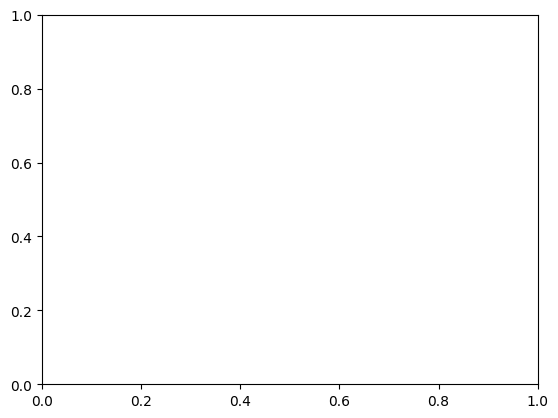

In [24]:
data = [sdr_list, sir_list, sar_list, si_sdr_list]

plt.boxplot(data, labels=['overall SDR', 'overall SIR', 'overall SAR', 'overall SI-SDR'])
plt.title('Boxplot of objective evaluation metrics')
# plt.savefig('./test/surdeterm/complete objective evaluation.pdf', bbox_inches='tight')
plt.show()